In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import shap
import multiprocessing as mp
import matplotlib.pyplot as plt
from pathlib import Path
from dotenv import load_dotenv

# ---------------- paths ----------------
load_dotenv()
ROOT = Path(os.getenv("ROOT", ".")).expanduser()
DATA_DIR = ROOT / "data" / "preprocessed"
MODELS_DIR = ROOT / "models"
FIG_DIR = ROOT / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PATH = DATA_DIR / "train-data.npy"
TEST_PATH  = DATA_DIR / "test-data.npy"

# Choose which trained model to explain
MODEL_NAME = "mlp.pkl"  # e.g. 'dt.pkl', 'rf.pkl', 'svc.pkl', 'mlp.pkl', 'xgb.pkl', 'voting_classifier.pkl'
MODEL_PATH = MODELS_DIR / MODEL_NAME


# ---------------- feature names ----------------
feature_names_all = [
    # counts of activities
    'all_activities_count', 'attempt_viewed_count', 'course_module_viewed_count',
    # counts of day_type_time_of_day
    'workday_morning_count', 'workday_afternoon_count', 'workday_evening_count',
    'weekend_morning_count', 'weekend_afternoon_count', 'weekend_evening_count',
    # counts of inactivity
    'days_inactive_since_last_activity', 'days_inactive',
    # days since start
    'date_rel',
    # attempt info
    'attemptnr', 'previous_attempts', 'previous_perf',
    # statistical features
    'stat_min', 'stat_max', 'stat_mean', 'stat_median', 'stat_sd', 'stat_skew', 'stat_kurtosis'
]
excluded_features = [
    'all_activities_count',
    'attempt_viewed_count',
    'course_module_viewed_count',
    'days_inactive_since_last_activity',
    'date_rel',
    'stat_max',
]
feature_names = [feat for feat in feature_names_all if feat not in excluded_features]


# ---------------- helpers ----------------
def load_np(path, with_groups=False):
    """Load .npy produced by save_data() in data_preprocessing.py."""
    arr = np.load(open(path, "rb"))
    if with_groups:
        return arr[:, :-2], arr[:, -2], arr[:, -1]
    else:
        return arr[:, :-1], arr[:, -1]


def make_predict_fn(model):
    """
    Return a callable f(X) -> 1D score/prob for the positive class.
    Works with any sklearn pipeline/estimator that implements predict_proba
    (preferred), otherwise falls back to decision_function or predict.
    """
    if hasattr(model, "predict_proba"):
        def f(X):
            proba = model.predict_proba(X)
            return proba[:, 1] if proba.shape[1] == 2 else proba.max(axis=1)
        return f
    elif hasattr(model, "decision_function"):
        def f(X):
            s = model.decision_function(X)
            return s.ravel() if hasattr(s, "shape") else np.asarray(s)
        return f
    else:
        def f(X):
            y = model.predict(X)
            return y.astype(float)
        return f



c:\Users\behnam.parsaeifard\AppData\Local\miniconda3\envs\aida\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Load data
X_train, y_train, groups = load_np(TRAIN_PATH, with_groups=True)
X_test,  y_test = load_np(TEST_PATH, with_groups=False)

# Load model (pipeline or estimator)
model = joblib.load(MODEL_PATH)
print(f"Loaded model: {MODEL_NAME}")

# Background sample for SHAP
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=500, random_state=42)
idx_bg, _ = next(split.split(X_train, y_train))
background = X_train[idx_bg]
# background = shap.sample(X_train, 200)  # smaller = faster

# Create unified SHAP explainer
f = make_predict_fn(model)
explainer = shap.Explainer(f, background, feature_names=feature_names)

def compute_shap_chunk(chunk):
        return explainer(chunk)
    
def compute_shap_parallel(X, cpu_count=None):

    if cpu_count is None:
        cpu_count = multiprocessing.cpu_count()
        
    # Split X_test into chunks to distribute across processes
    chunk_size = len(X) // cpu_count
    chunks = [X[i:i + chunk_size] for i in range(0, len(X), chunk_size)]
    
    with multiprocessing.Pool(processes=cpu_count) as pool:
        out = pool.map(compute_shap_chunk, chunks)

    data = np.concatenate([o.data for o in out], axis=0)
    base_values = np.concatenate([o.base_values for o in out], axis=0)
    values = np.concatenate([o.values for o in out], axis=0)
    feature_names = out[0].feature_names

    return shap.Explanation(values, base_values=base_values, data=data, feature_names=feature_names)

# Compute SHAP values
shap_values = explainer(X_test)

# Compute SHAP values in parallel (alternative -- in linux/macOS)
# shap_values = compute_shap_parallel(X_test)

shap_values


Loaded model: mlp.pkl


PermutationExplainer explainer: 8591it [27:27,  5.21it/s]                          


.values =
array([[-0.09266253, -0.17725082, -0.1180356 , ..., -0.04051198,
        -0.02227733,  0.00733628],
       [-0.0907008 , -0.16831048, -0.11832603, ..., -0.04147025,
        -0.01625801, -0.00116544],
       [-0.05764664, -0.10806293, -0.07991366, ..., -0.03954238,
         0.00170364, -0.00721596],
       ...,
       [ 0.43344905, -0.08456672, -0.08155147, ..., -0.03005847,
         0.00415574,  0.0016958 ],
       [ 0.34610519, -0.10320404, -0.091363  , ..., -0.03123268,
         0.0167025 ,  0.00942888],
       [ 0.42674173, -0.08357799, -0.08062677, ..., -0.03062371,
         0.00665184,  0.0006207 ]], shape=(8590, 16))

.base_values =
array([0.47186579, 0.47186579, 0.47186579, ..., 0.47186579, 0.47186579,
       0.47186579], shape=(8590,))

.data =
array([[  0.        ,   0.        ,   2.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   2.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.   

C:\Users\behnam.parsaeifard\AppData\Local\Temp\ipykernel_9012\1078397037.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


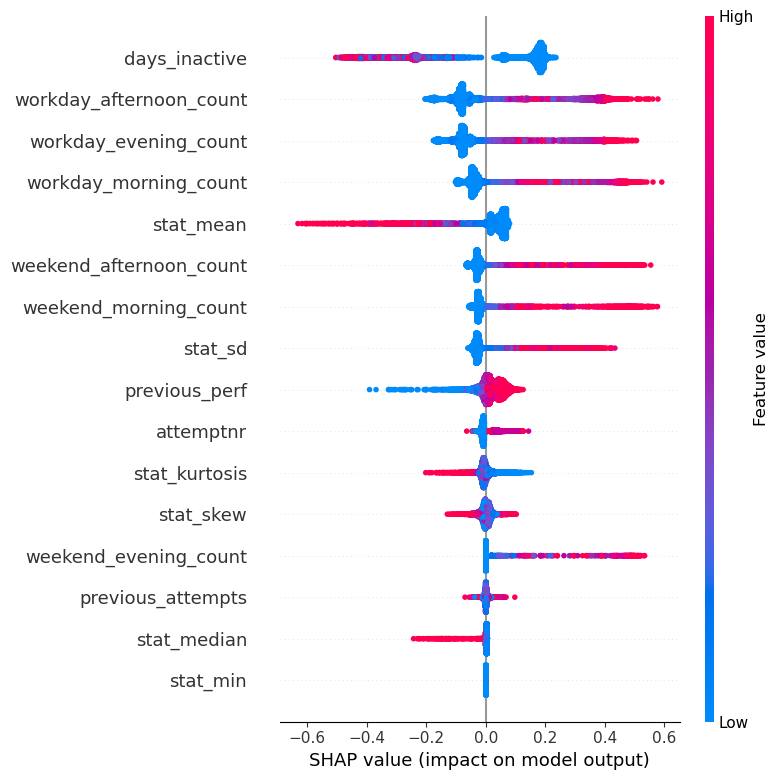

✅ SHAP summary saved to: C:\Users\behnam.parsaeifard\Downloads\aida-project\figures\shap_summary_mlp.png


In [3]:
# ---------------- plots ----------------
# Summary plot (beeswarm)
shap.summary_plot(
    shap_values.values if hasattr(shap_values, "values") else shap_values,
    X_test,
    feature_names=feature_names,
    show=True
)

# Save figure
out_path = FIG_DIR / f"shap_summary_{MODEL_NAME.replace('.pkl', '')}.png"
# plt.gcf().savefig(out_path, bbox_inches="tight", dpi=300)
print(f"✅ SHAP summary saved to: {out_path}")

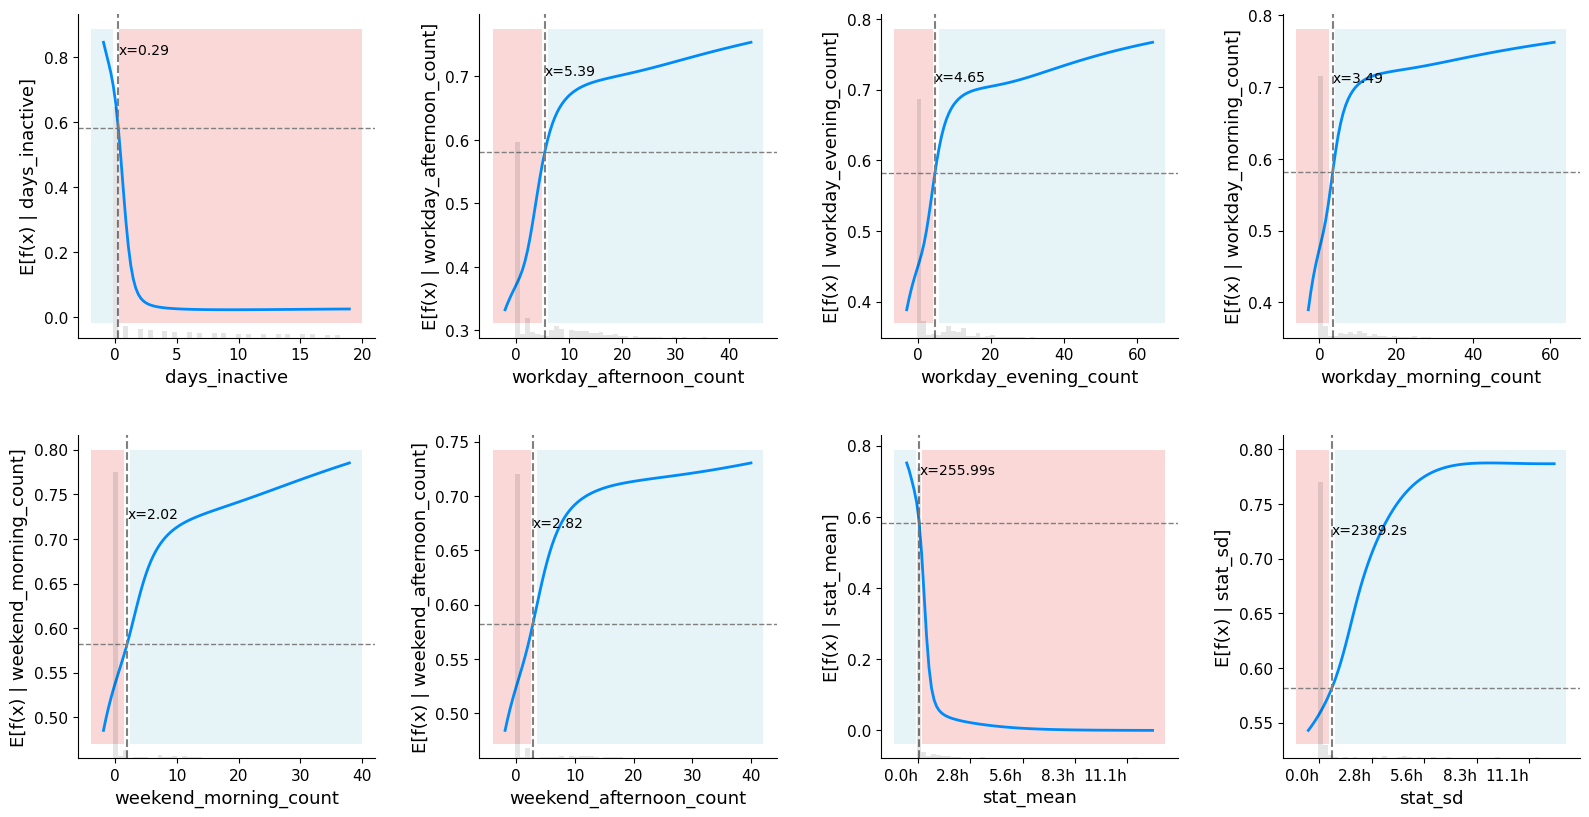

In [5]:
import matplotlib.gridspec as gridspec
import math

def find_x_thresh(idx, x, model, xmin=None, xmax=None, points=100, threshold=0.5):
    """
    Finds the value of feature x[idx] where the model's predicted probability is closest to 0.5.

    Parameters:
    - idx: Index of the feature to vary.
    - x: Feature vector (NumPy array).
    - model: The model used for prediction.
    - xmin: Minimum value of the feature to search over (default is the 0th percentile of x).
    - xmax: Maximum value of the feature to search over (default is the 100th percentile of x).
    - points: Number of points to evaluate between xmin and xmax (default is 100).
    
    Returns:
    - x_thresh: The value of x[idx] where the model's predicted probability is closest to 0.5.
    """
    
    # Copy the feature matrix to avoid modifying the input
    features_tmp = x.copy()
    
    # Calculate default xmin and xmax if not provided (percentiles of the feature)
    if xmin is None:
        xmin = np.percentile(x[:, idx], 0)
    if xmax is None:
        xmax = np.percentile(x[:, idx], 100)
    
    # Generate evenly spaced points between xmin and xmax
    xs = np.linspace(xmin, xmax, points)
    
    # Array to hold the model predictions for each value of xs
    vals = np.zeros(points)
    
    # Iterate over the points and evaluate the model
    for i in range(points):
        features_tmp[:, idx] = xs[i]
        vals[i] = model(features_tmp).mean()
    
    # Find the value of xs where the prediction is closest to 0.5
    x_thresh = xs[np.argmin(np.abs(vals - threshold))]
    
    return x_thresh


top_features = [
    'days_inactive',
    'workday_afternoon_count',
    'workday_evening_count',
    'workday_morning_count',
    'weekend_morning_count',
    'weekend_afternoon_count',
    'stat_mean',
    'stat_sd'
]

time_features = ['stat_min', 'stat_mean', 'stat_median', 'stat_sd']
seconds_in_a_unit = 3600  # e.g., convert to hours
n_digits = 2
n_cols = 4
n_rows = math.ceil((len(top_features) - 1) / n_cols) + 1  # +1 row for the last plot in the middle

# Create a figure with GridSpec
fig = plt.figure(figsize=(n_cols * 4, n_rows * 4))
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig)
predictor_func = lambda x: model.predict_proba(x)[:, 1] # + 0.5 - shap_values.base_values[0].item()
base_val = predictor_func(X_test).mean()

for i, feat in enumerate(top_features):

    ax = fig.add_subplot(gs[i // n_cols, i % n_cols])
    # if i == len(top_features) - 1:
    #     # For the last feature, span the subplot across both columns in the last row
    #     ax = fig.add_subplot(gs[-1, :])  # Span across both columns
    # else:
    #     ax = fig.add_subplot(gs[i // n_cols, i % n_cols])  # Regular positioning

    feature_idx = feature_names.index(feat)  # Get the index of the feature
    
    # Create a partial dependence plot using SHAP
    shap.partial_dependence_plot(
        feature_idx,
        predictor_func,
        X_test,
        show=False,
        ice=False,
        feature_names=feature_names,
        ax=ax,
        # model_expected_value=True,
    )

    ax.axhline(base_val, linestyle='--', linewidth=1, color='gray')
    x_thresh = find_x_thresh(feature_idx, X_test, predictor_func, points=500, threshold=base_val)
    x_thresh = np.round(x_thresh, n_digits)
    x_thresh_text = f'{x_thresh}'

    if feat in time_features:
        xticks = ax.get_xticks()[1:-1]
        xmin, xmax = xticks[0], xticks[-1]
        xticks = np.linspace(xmin, xmax, 5)
        xtick_labels = xticks / seconds_in_a_unit

        ax.set_xticks(xticks)
        ax.set_xticklabels([f'{x:.1f}h' for x in xtick_labels], ha='right')
        # x_thresh_text = f'{np.round(x_thresh / 60, 1)}min'
        x_thresh_text = f'{x_thresh}s'
    
    ax.axvline(x=x_thresh, color='gray', linestyle='--')
    ax.text(x_thresh, ax.get_ylim()[1] * 0.9, f'x={x_thresh_text}', color='black', ha='left', va='bottom')

    if feat.endswith('count') or feat == 'stat_sd':
        # Shade the left and right regions
        xx = np.linspace(*ax.get_xlim())
        yy1 = ax.get_ylim()[0]
        yy2 = ax.get_ylim()[1]
        # ax.fill_between(xx, yy1, yy2, where=xx < x_thresh, 
        #                 facecolor='lightblue', alpha=0.3)
        # ax.fill_between(xx, yy1, yy2, where=xx > x_thresh, 
        #                 facecolor='lightcoral', alpha=0.3)
        ax.fill_between(xx, yy1, yy2, where=xx < x_thresh, 
                        facecolor='lightcoral', alpha=0.3)
        ax.fill_between(xx, yy1, yy2, where=xx > x_thresh, 
                        facecolor='lightblue', alpha=0.3)
    else:
        # Shade the left and right regions
        xx = np.linspace(*ax.get_xlim())
        yy1 = ax.get_ylim()[0]
        yy2 = ax.get_ylim()[1]
        # ax.fill_between(xx, yy1, yy2, where=xx > x_thresh, 
        #                 facecolor='lightblue', alpha=0.3)
        # ax.fill_between(xx, yy1, yy2, where=xx < x_thresh, 
        #                 facecolor='lightcoral', alpha=0.3)
        ax.fill_between(xx, yy1, yy2, where=xx > x_thresh, 
                        facecolor='lightcoral', alpha=0.3)
        ax.fill_between(xx, yy1, yy2, where=xx < x_thresh, 
                        facecolor='lightblue', alpha=0.3)

    # Rotate x-axis labels 45 degrees for better readability
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.35, hspace=0.3)

# Figure 8 
# plt.savefig(FIG_DIR / f"detailed-dependence-plot_{MODEL_NAME.replace('.pkl', '')}.pdf")

# Show the plot
plt.show()

In [6]:
def find_risk_level(inactivity, time_mismanagement, irregularity):
    if inactivity and time_mismanagement:
        return "high"
    elif inactivity or time_mismanagement:
        return "medium"
    elif irregularity:
        return "low"
    else:
        return "engaged"
    
top_features = [
    "days_inactive",
    "workday_afternoon_count",
    "workday_evening_count",
    "workday_morning_count",
    "stat_mean",
    "weekend_morning_count",
    "weekend_afternoon_count",
    "stat_sd"
]

idx = range(len(shap_values))
counts = {
    'critical': {"count":0, "de_count": 0, "idx_1": [], "idx_0": []}, 
    'high': {"count":0, "de_count": 0, "idx_1": [], "idx_0": []},
    'medium': {"count":0, "de_count": 0, "idx_1": [], "idx_0": []},
    'medium1': {"count":0, "de_count": 0, "idx_1": [], "idx_0": []},
    "low": {"count":0, "de_count": 0, "idx_1": [], "idx_0": []},
    "engaged": {"count":0, "de_count": 0, "idx_1": [], "idx_0": []}
}

for i in idx:
    sv = shap_values[i]
    info = {k: (sv.data[j].item(), sv.values[j].item()) for j,k in enumerate(sv.feature_names)}

    time_mismanagement = info['days_inactive'][1] < 0
    inactivity = info['workday_afternoon_count'][1] + info['workday_evening_count'][1] + info['workday_morning_count'][1] + \
                        info['weekend_morning_count'][1] + info['weekend_afternoon_count'][1] < 0 
    irregularity = info['stat_mean'][1] + info['stat_sd'][1] < 0
    rest = sum([info[k][1] for k in info if k not in top_features])

    risk_level = find_risk_level(inactivity, time_mismanagement, irregularity)

    predicted_as_disengaged = model.predict(shap_values.data[i][None,:]) == 0
    counts[risk_level]["count"] += 1
    counts[risk_level]["de_count"] += (1 if predicted_as_disengaged else 0)
    if predicted_as_disengaged:
        counts[risk_level]["idx_0"].append(i)
    else:
        counts[risk_level]["idx_1"].append(i)

for k in counts:
    counts[k]['idx_1'] = np.array(counts[k]['idx_1'] )
    counts[k]['idx_0'] = np.array(counts[k]['idx_0'] )
counts

{'critical': {'count': 0,
  'de_count': 0,
  'idx_1': array([], dtype=float64),
  'idx_0': array([], dtype=float64)},
 'high': {'count': 1813,
  'de_count': 1810,
  'idx_1': array([2628, 2780, 6613]),
  'idx_0': array([   2,    3,    4, ..., 8533, 8534, 8535], shape=(1810,))},
 'medium': {'count': 1791,
  'de_count': 1372,
  'idx_1': array([  47,   53,   90,  128,  187,  195,  196,  209,  227,  228,  248,
          250,  260,  267,  269,  286,  288,  290,  297,  309,  310,  340,
          341,  342,  343,  344,  375,  376,  377,  381,  383,  387,  391,
          393,  394,  396,  400,  403,  406,  409,  413,  479,  483,  531,
          545,  546,  551,  552,  622,  623,  630,  631,  683,  718,  737,
          743,  787,  812,  813,  816,  821,  869,  870,  871,  872,  887,
          912,  925, 1020, 1142, 1177, 1178, 1179, 1230, 1235, 1236, 1242,
         1243, 1249, 1256, 1275, 1286, 1290, 1294, 1296, 1298, 1302, 1377,
         1406, 1552, 1564, 1565, 1585, 1609, 1793, 1815, 1839, 184

In [11]:
_ = pd.DataFrame(counts).loc[["count", "de_count"], ['high','medium', 'medium1', 'low','engaged']]

_['medium'] = _['medium'] + _['medium1']
_ = _.drop(columns=['medium1'])
_
print(_.to_latex())

\begin{tabular}{lllll}
\toprule
 & high & medium & low & engaged \\
\midrule
count & 1813 & 1791 & 517 & 4469 \\
de_count & 1810 & 1372 & 58 & 14 \\
\bottomrule
\end{tabular}



i=np.int64(2099) risk_level='engaged' cat='idx_1' prediction: [1.]


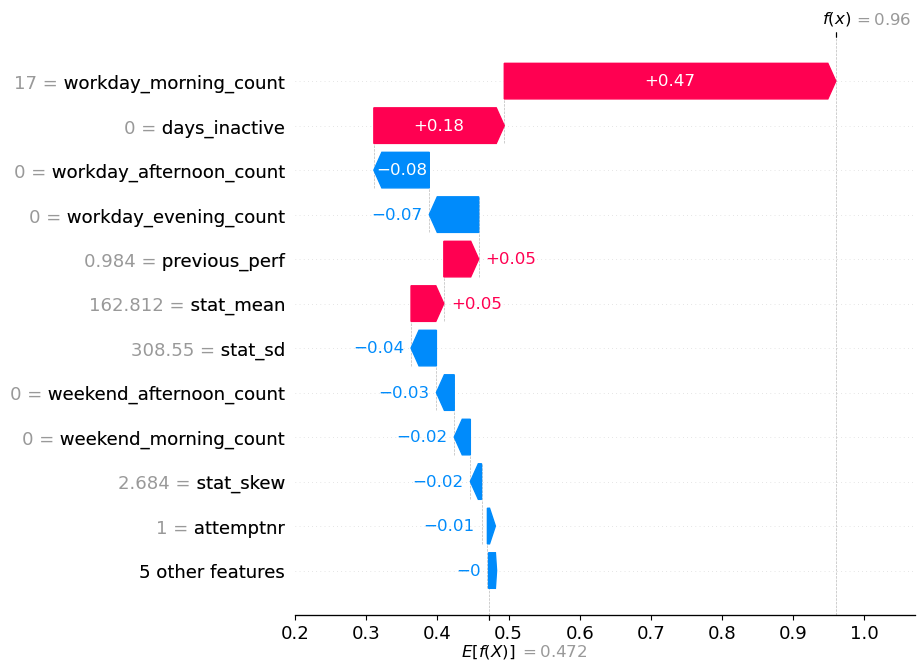

In [ ]:
SHOW = True

# for risk_level in ('high', 'medium', 'medium1', 'low', 'engaged'):
for risk_level in ('engaged',):

    cat = 'idx_0' if risk_level in ('high','medium', 'medium1', 'low') else 'idx_1'
    i = np.random.choice(counts[risk_level][cat])
    print(f'{i=} {risk_level=} {cat=} prediction: {model.predict(X_test[i][None,:])}')
    ax = shap.plots.waterfall(shap_values[i], max_display=12, show=SHOW)
    
    # plt.savefig(f'figures/{risk_level}-risk-example.png', bbox_inches='tight')
    # plt.savefig(FIG_DIR / f"{risk_level}-risk-example_{MODEL_NAME.replace('.pkl', '')}.png", bbox_inches='tight')
    plt.show()